In [250]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th


In [251]:
xs = th.tensor([
    np.array((0,-2.)),
    np.array((0,0.)),
    np.array((-2,0.)),
]).to(th.float32)
zs = th.tensor([
    0.,
    1.,
    0.
]).to(th.float32)

In [252]:
th.eye(2).repeat(3,1).shape

torch.Size([6, 2])

In [255]:
def forward(xs, points):
    alpha = 10
    W, B = th.eye(2).repeat(len(xs),1), -xs.reshape(-1)
    h = th.nn.functional.linear(points, W, B)
    h = -th.relu(-h)

    W = th.zeros((xs.shape[0], h.shape[1]))
    for i_ in range(xs.shape[0]):
        i = i_*2
        W[i_,i:i+2] = 1

    h = th.nn.functional.linear(h, alpha*W, th.ones((xs.shape[0])))
    h = th.relu(h)

    W = th.ones(len(xs), len(xs)).triu()
    h = th.nn.functional.linear(h, W, th.ones((xs.shape[0])))
    h = th.relu(h)

    return h

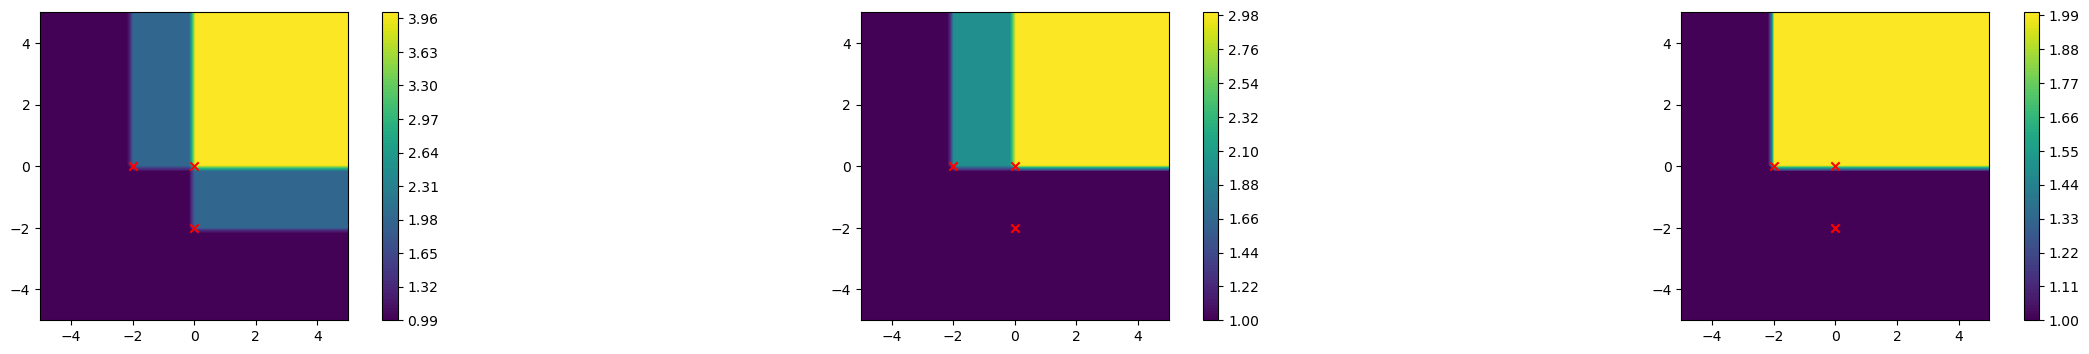

In [256]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
input_data = np.vstack([X.ravel(), Y.ravel()]).T
input_tensor = th.tensor(input_data, dtype=th.float32)
Z = forward(xs, input_tensor).numpy()
plt.figure(figsize=(30, 4))
for i in range(Z.shape[-1]):
    z = Z[...,i].reshape(X.shape)
    plt.subplot(1, Z.shape[-1], i+1)
    plt.gca().set_aspect('equal')
    plt.contourf(X, Y, z, levels=100, cmap='viridis')
    plt.colorbar()
    plt.scatter(xs[:, 0], xs[:, 1], color='red', marker='x')

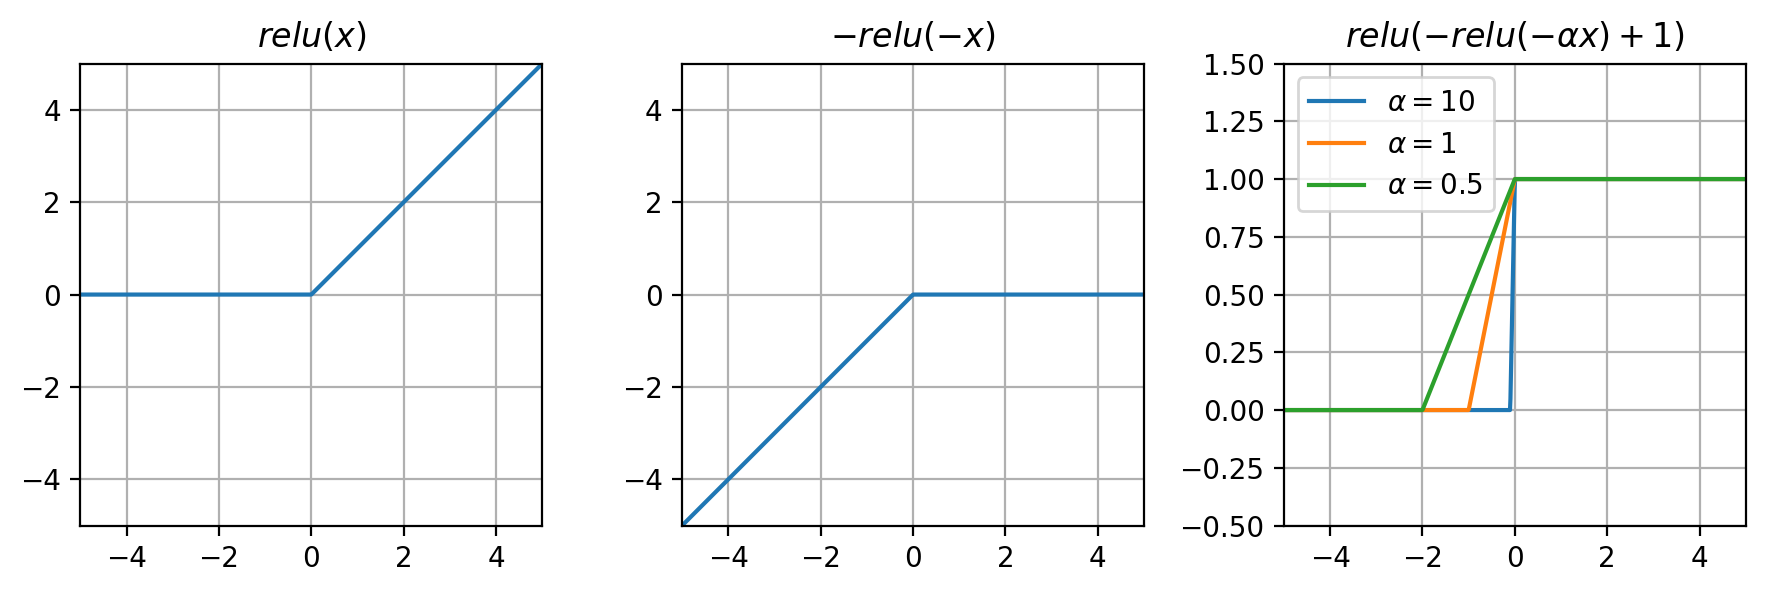

In [249]:
x = np.linspace(-5, 5, 1000)
fig, axs = plt.subplots(1,3, dpi=200, figsize=(11,3))
axs[0].plot(x, np.maximum(0, x))
axs[0].set_xlim(-5, 5)
axs[0].set_ylim(-5, 5)
axs[0].grid()
axs[0].set_title("$relu(x)$")
axs[0].set_aspect('equal')

axs[1].plot(x, -np.maximum(0, -x))
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
axs[1].grid()
axs[1].set_title("$-relu(-x)$")
axs[1].set_aspect('equal')

axs[2].plot(x, np.maximum(-np.maximum(0, -10*x) + 1,0), label="$\\alpha=10$")
axs[2].plot(x, np.maximum(-np.maximum(0, -1*x) + 1,0), label="$\\alpha=1$")
axs[2].plot(x, np.maximum(-np.maximum(0, -0.5*x) + 1,0), label="$\\alpha=0.5$")
axs[2].set_xlim(-5, 5)
axs[2].set_ylim(-0.5, 1.5)
axs[2].grid()
axs[2].set_title("$relu(-relu(-\\alpha x)+1)$")
axs[2].legend()
axs[2].set_box_aspect(1)

plt.savefig("/Users/albertosinigaglia/Desktop/relu.pdf")

## Plots

In [ ]:
import numpy as np
from tqdm import trange
x = torch.tensor(np.linspace(-3, 10, 1000)).to(torch.float32).reshape(-1, 1)
y = (np.cos(x)+x).clone().detach().to(torch.float32)

In [ ]:
class SimpleLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimpleLinear, self).__init__()
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features, requires_grad=True)*0.01)
        self.bias = torch.nn.Parameter(torch.randn(out_features, requires_grad=True)*0.01)

    def forward(self, input):
        return input.mm(self.weight.t().abs()) + self.bias
    
class ReluTwisted(nn.Module):
    def forward(self, input):
        return -torch.relu(-input)

In [ ]:
STEPSIZE=0.003

DIM  = 128
our_model = nn.Sequential(
    MonotonicLinear(1, DIM, pre_activation=nn.Identity()),
    MonotonicLinear(DIM, DIM, pre_activation=nn.ReLU()),
    MonotonicLinear(DIM, 1, pre_activation=nn.ReLU()),
)
bad_model = nn.Sequential(
    SimpleLinear(1, DIM),
    torch.nn.ReLU(),
    SimpleLinear(DIM, DIM),
    torch.nn.ReLU(),
    SimpleLinear(DIM, 1),
)
sigmoid_model = nn.Sequential(
    MonotonicLinear(1, DIM, weight_parametrization='abs'),
    nn.Sigmoid(),
    MonotonicLinear(DIM, DIM, weight_parametrization='abs'),
    nn.Sigmoid(),
    MonotonicLinear(DIM, 1, weight_parametrization='abs'),
)
model = nn.Sequential(
    torch.nn.LazyLinear(DIM),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(DIM),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(1),
)
our_opt = torch.optim.Adam(our_model.parameters(), lr=STEPSIZE)
bad_opt = torch.optim.Adam(bad_model.parameters(), lr=STEPSIZE)
opt = torch.optim.Adam(model.parameters(), lr=STEPSIZE)
sigmoid_opt = torch.optim.Adam(sigmoid_model.parameters(), lr=STEPSIZE)

models = [
    ["uncontrained", model, opt],
    ["relu", bad_model, bad_opt],
    ["sigmoid", sigmoid_model, sigmoid_opt],
    ["proposedauto", our_model, our_opt],
]


OTHERDIM = 256
our_model_other = nn.Sequential(
    MonotonicLinear(1, OTHERDIM, pre_activation=nn.Identity()),
    MonotonicLinear(OTHERDIM, OTHERDIM, pre_activation=nn.ReLU()),
    MonotonicLinear(OTHERDIM, 1, pre_activation=nn.ReLU()),
)
bad_model_other = nn.Sequential(
    SimpleLinear(1, OTHERDIM),
    torch.nn.ReLU(),
    SimpleLinear(OTHERDIM, OTHERDIM),
    torch.nn.ReLU(),
    SimpleLinear(OTHERDIM, 1),
)
sigmoid_model_other = nn.Sequential(
    MonotonicLinear(1, OTHERDIM, weight_parametrization='abs'),
    nn.Sigmoid(),
    MonotonicLinear(OTHERDIM, OTHERDIM, weight_parametrization='abs'),
    nn.Sigmoid(),
    MonotonicLinear(OTHERDIM, 1, weight_parametrization='abs'),
)
model_other = nn.Sequential(
    torch.nn.LazyLinear(OTHERDIM),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(OTHERDIM),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(1),
)
our_opt_other = torch.optim.Adam(our_model_other.parameters(), lr=STEPSIZE)
bad_opt_other = torch.optim.Adam(bad_model_other.parameters(), lr=STEPSIZE)
opt_other = torch.optim.Adam(model_other.parameters(), lr=STEPSIZE)
sigmoid_opt_other = torch.optim.Adam(sigmoid_model_other.parameters(), lr=STEPSIZE)

models_other = [
    ["uncontrained", model_other, opt_other],
    ["relu", bad_model_other, bad_opt_other],
    ["sigmoid", sigmoid_model_other, sigmoid_opt_other],
    ["proposedauto", our_model_other, our_opt_other],
]

/opt/homebrew/Caskroom/miniforge/base/envs/ml-apple-metal/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
model_losses = {name: [] for name, _, _ in models}
model_other_losses = {name: [] for name, _, _ in models_other}
for _ in trange(1000):
    for name_, model_, opt_ in models:
        opt_.zero_grad()
        loss_ = torch.nn.functional.mse_loss(model_(x), y)
        loss_.backward()
        opt_.step()
        model_losses[name_].append(loss_.item())
    for name_, model_, opt_ in models_other:
        opt_.zero_grad()
        loss_ = torch.nn.functional.mse_loss(model_(x), y)
        loss_.backward()
        opt_.step()
        model_other_losses[name_].append(loss_.item())

100%|██████████| 1000/1000 [01:21<00:00, 12.33it/s]


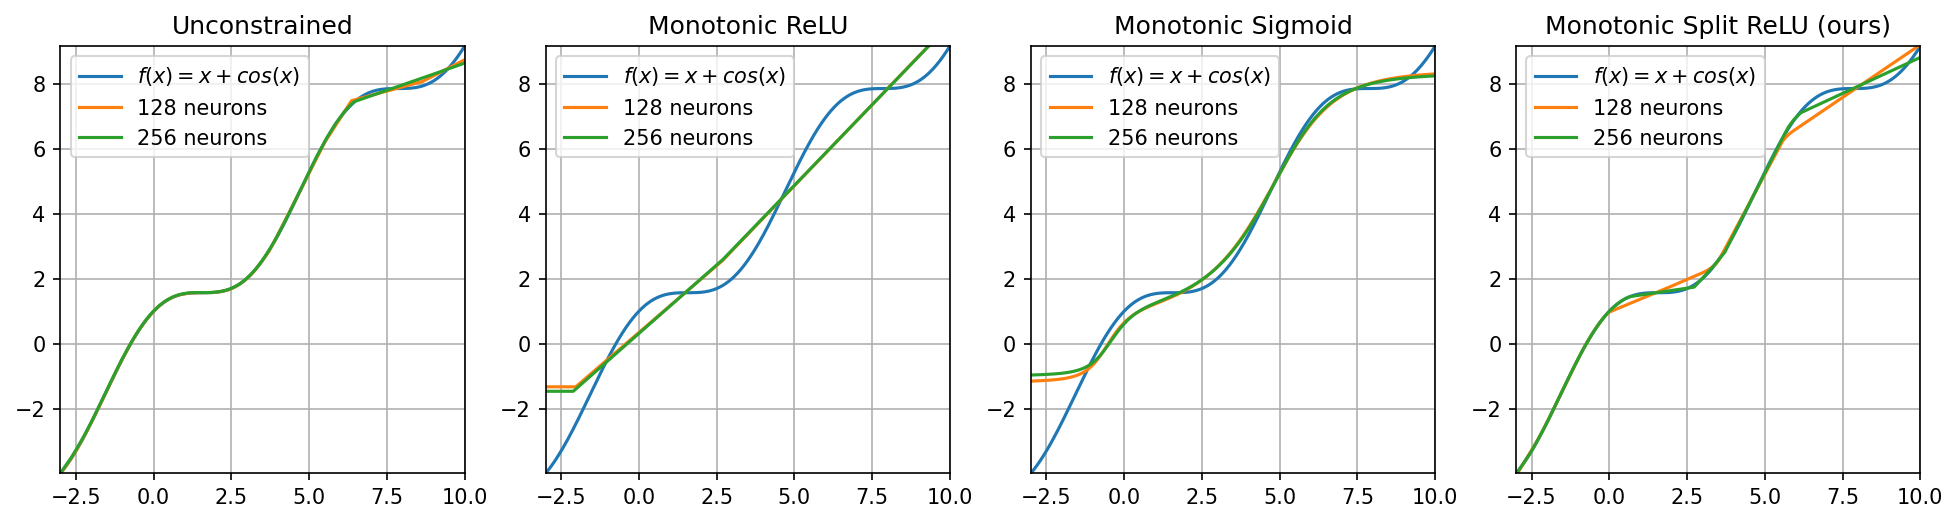

In [ ]:
fig, axs = plt.subplots(1, len(models), figsize=(16, 3.7), dpi=150)
titles=[
    "Unconstrained",
    "Monotonic ReLU",
    "Monotonic Sigmoid",
    "Monotonic Split ReLU (ours)",
]
for i in range(len(models)):
    axs[i].plot(x,y, label="$f(x)=x+cos(x)$")
    axs[i].plot(x, models[i][1](x).detach(), label=f"{DIM} neurons")
    axs[i].plot(x, models_other[i][1](x).detach(), label=f"{OTHERDIM} neurons")
    axs[i].set_title(titles[i])
    axs[i].legend()
    axs[i].grid()
    axs[i].set_xlim(x.min(), x.max())
    axs[i].set_ylim(y.min(), y.max())

plt.savefig("/Users/albertosinigaglia/Desktop/comparison.pdf")

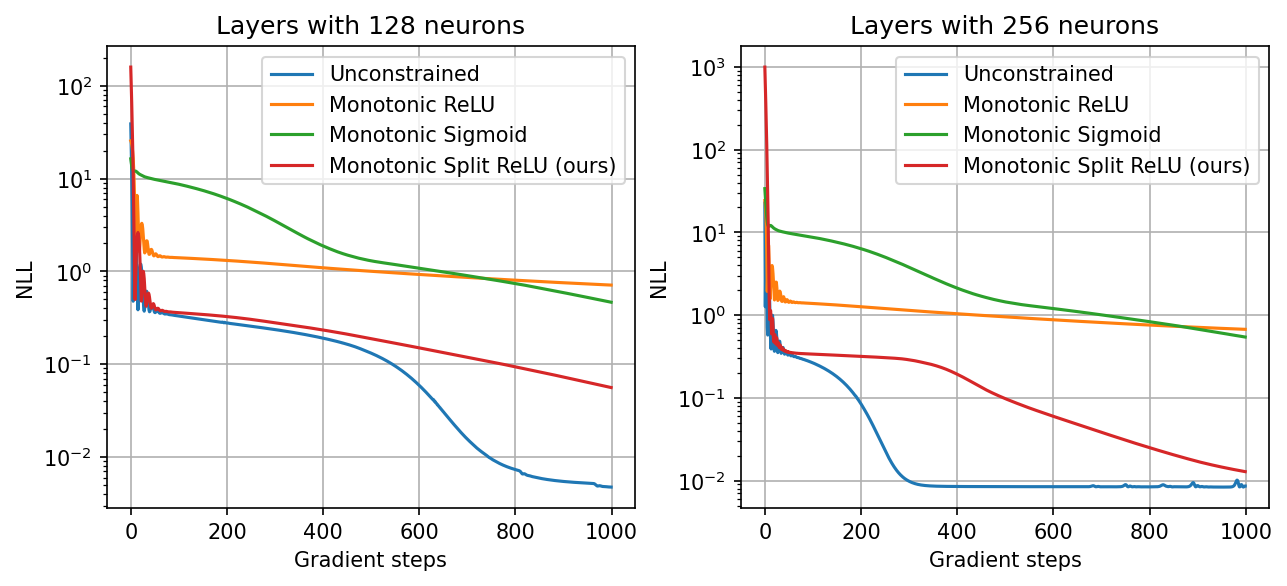

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), dpi=150)
for (_, loss), name in zip(model_losses.items(), titles):
    axs[0].semilogy(loss, label=name)

for (_, loss), name in zip(model_other_losses.items(), titles):
    axs[1].semilogy(loss, label=name)

axs[0].set_ylabel("NLL")
axs[1].set_ylabel("NLL")
axs[0].set_xlabel("Gradient steps")
axs[1].set_xlabel("Gradient steps")

axs[0].set_title(f"Layers with {DIM} neurons")
axs[1].set_title(f"Layers with {OTHERDIM} neurons")

axs[0].legend()
axs[0].grid()
axs[1].legend()
axs[1].grid()

plt.savefig("/Users/albertosinigaglia/Desktop/losses.pdf")